In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Convolution2D, Flatten, Dropout,GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models,optimizers
from keras import layers
from tensorflow import keras
from keras import metrics
from keras.applications.inception_resnet_v2 import preprocess_input
from attention import AttentionLayer
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
#import keras
import numpy as np
import warnings
warnings.filterwarnings('ignore')

2022-06-27 00:05:17.701593: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2022-06-27 00:05:19.652423: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-27 00:05:19.712426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 00:05:19.713154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:24:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.86GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2022-06-27 00:05:19.713184: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-06-27 00:05:19.745030: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-06-27 00:05:19.763120: I tensorflow/stream_executor/plat

In [3]:
def plotResults(history):
        
    # Accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('images/accuracy.png')
    plt.show()
    plt.close()
    
    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('images/loss.png')
    plt.show()
    plt.close()

In [4]:
datadir = "./data/akac_gen.txt"

['famid', 'pid', 'fatid', 'motid', 'sex', 'affected', 'rs3737967', 'rs1537514', 'rs2274976', 'rs1801131', 'rs1801133', 'rs9651118', 'rs3753582', 'rs4147871', 'rs560426', 'rs1209169', 'rs481931', 'rs12089548', 'rs16827741', 'rs2228099', 'rs11204737', 'rs3768012', 'rs7517566', 'rs1044516', 'rs599021', 'rs17317411', 'rs2235373', 'rs2235371', 'rs2235375', 'rs595918', 'rs17015218', 'rs2013162', 'rs3821272', 'rs930655', 'rs3732247', 'rs765871', 'rs3771498', 'rs3771497', 'rs3755377', 'rs3771485', 'rs11466212', 'rs3771475', 'rs1139', 'rs3821949', 'rs12532', 'rs4464513', 'rs698', 'rs1693482', 'rs2241894', 'rs2255796', 'rs7713638', 'rs7715100', 'rs15251', 'rs16873348', 'rs910586', 'rs2819861', 'rs1934328', 'rs987525', 'rs7078160', 'rs7940667', 'rs7103685', 'rs931953', 'rs10790330', 'rs906830', 'rs7129848', 'rs3935406', 'rs10892434', 'rs4409845', 'rs2136421', 'rs2295221', 'rs7142363', 'rs2073247', 'rs17104928', 'rs17176643', 'rs11156925', 'rs17104939', 'rs17104944', 'rs17104965', 'rs1884213', 'rs

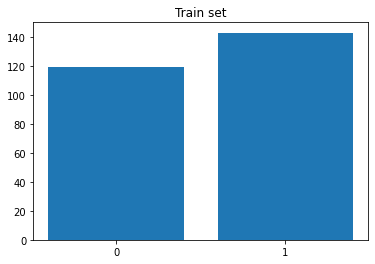

(200, 10)


dtype('float64')

In [26]:
dataset = pd.read_csv(datadir, delimiter ="\t", header = 0)
dataset = dataset.sample(frac=1,random_state=777)

SNPs = ['rs2235375','rs1044516','rs11204737','rs1044516','rs7715100','rs3917192','rs2235371']
snps = ['rs7078160','rs3753582','rs2235373','rs1429591','rs1801133','rs906830','rs2013162','rs1044516','rs3917192','rs7103685']
dataset.head()
del_list = ["famid", "pid", "fatid", "motid", "sex","rs12089548","rs11466414"]
for i in del_list:
    del dataset[i]
    
y_train = pd.to_numeric(dataset['affected']) -1
X_train = dataset[snps]
del dataset['affected']

import matplotlib.pyplot as plt

plt.bar([1,2],[y_train.shape[0]-int(y_train.sum()), int(y_train.sum())], align='center')
plt.title('Train set')
plt.xticks([1,2], ['0', '1'])
plt.show()
plt.close()

num_train =200
x_train_np = np.array(X_train)[:num_train]
x_test_np = np.array(X_train)[num_train:]
y_train_np = np.array(y_train)[:num_train]
y_test_np = np.array(y_train)[num_train:]

input_dim = X_train.shape[1]
x_train_np = x_train_np.astype("float")
x_test_np = x_test_np.astype("float")
y_train_np = y_train_np.astype("float")
y_test_np = y_test_np.astype("float")
x_train_np.dtype

In [52]:
size = 32
init = keras.initializers.he_normal(seed=777)
model = Sequential()
model.add(Dense(size,input_dim = input_dim,activation='relu',bias_initializer=init))
model.add(Dense(size*2,input_dim = size,activation='relu',bias_initializer=init))
model.add(Dense(size*2,input_dim = size,activation='relu',bias_initializer=init))
model.add(Dense(1,input_dim = size,activation='sigmoid', name='lastfc',bias_initializer=init))
model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
model.summary()

class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_accuracy',patience=50, verbose=1,restore_best_weights=True, mode='auto', start_epoch = 20): # add argument for starting epoch
        super(CustomStopper, self).__init__(monitor=monitor,patience=patience,mode=mode,verbose=verbose,restore_best_weights=restore_best_weights)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
lastfc (Dense)               (None, 1)                 65        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [53]:
filepath = "./model/16snp6_ann-{epoch:02d}-{val_accuracy:.2f}.h5"
save_best = ModelCheckpoint(filepath =filepath, monitor='val_loss', mode ='auto', save_best_only = False, save_weights_only = False)
opt = optimizers.Adam(lr=5e-3,decay=1e-5)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
Earlystop = CustomStopper()
history = model.fit(x_train_np, y_train_np, epochs=100, verbose=2, validation_data=(x_test_np,y_test_np), callbacks=[Earlystop])


Epoch 1/100
7/7 - 0s - loss: 0.2747 - accuracy: 0.5250 - val_loss: 0.2455 - val_accuracy: 0.5000
Epoch 2/100
7/7 - 0s - loss: 0.2441 - accuracy: 0.5550 - val_loss: 0.2640 - val_accuracy: 0.4677
Epoch 3/100
7/7 - 0s - loss: 0.2364 - accuracy: 0.6300 - val_loss: 0.2256 - val_accuracy: 0.6452
Epoch 4/100
7/7 - 0s - loss: 0.2326 - accuracy: 0.6550 - val_loss: 0.2782 - val_accuracy: 0.4677
Epoch 5/100
7/7 - 0s - loss: 0.2223 - accuracy: 0.6550 - val_loss: 0.2153 - val_accuracy: 0.6129
Epoch 6/100
7/7 - 0s - loss: 0.2213 - accuracy: 0.6500 - val_loss: 0.2595 - val_accuracy: 0.4839
Epoch 7/100
7/7 - 0s - loss: 0.2145 - accuracy: 0.6550 - val_loss: 0.2342 - val_accuracy: 0.5806
Epoch 8/100
7/7 - 0s - loss: 0.2095 - accuracy: 0.6650 - val_loss: 0.2842 - val_accuracy: 0.4839
Epoch 9/100
7/7 - 0s - loss: 0.2079 - accuracy: 0.6600 - val_loss: 0.2498 - val_accuracy: 0.5484
Epoch 10/100
7/7 - 0s - loss: 0.1963 - accuracy: 0.7200 - val_loss: 0.2618 - val_accuracy: 0.5161
Epoch 11/100
7/7 - 0s - loss:

Epoch 85/100
7/7 - 0s - loss: 0.0273 - accuracy: 0.9750 - val_loss: 0.4181 - val_accuracy: 0.4677
Epoch 86/100
7/7 - 0s - loss: 0.0298 - accuracy: 0.9700 - val_loss: 0.4375 - val_accuracy: 0.4194
Epoch 87/100
7/7 - 0s - loss: 0.0280 - accuracy: 0.9650 - val_loss: 0.4139 - val_accuracy: 0.4677
Epoch 88/100
Restoring model weights from the end of the best epoch.
7/7 - 0s - loss: 0.0279 - accuracy: 0.9700 - val_loss: 0.4094 - val_accuracy: 0.4677
Epoch 00088: early stopping


1/1 - 0s - loss: 0.1316 - accuracy: 0.8200
1/1 - 0s - loss: 0.2811 - accuracy: 0.6774
test auc
0.5581699346405228
train auc
0.9492296918767507


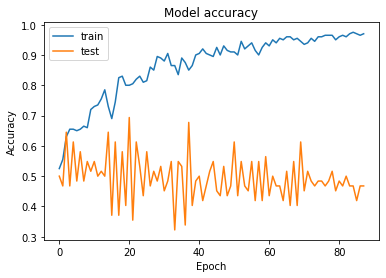

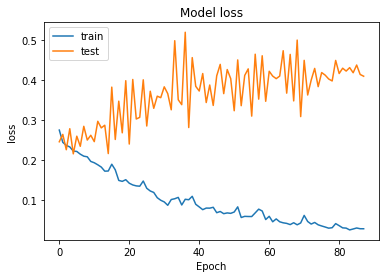

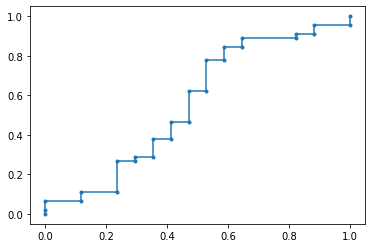

In [54]:
#model = keras.models.load_model("./model/16snp6_ann-69-0.58.h5")
test_loss, test_acc = model.evaluate(x_train_np, y_train_np, batch_size=200, verbose=2)
test_loss, test_acc = model.evaluate(x_test_np, y_test_np, batch_size=100, verbose=2)

print('test auc')
predict_test = model.predict(x_test_np, batch_size=20)
print(roc_auc_score(y_test_np, predict_test))
print('train auc')
predict_train = model.predict(x_train_np, batch_size=20)
print(roc_auc_score(y_train_np, predict_train))


plotResults(history)

from sklearn.metrics import roc_curve, auc
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test_np, predict_test)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [12]:
fitness_a = []
for k,j in zip(history.history["val_accuracy"], history.history["accuracy"]):
    fitness_a.append((k+j)/2)  
print(max(fitness_a))
print(fitness_a.index(max(fitness_a)))

0.7753225862979889
71


In [13]:
fitness_a = []
for k,j in zip(history.history["val_loss"], history.history["loss"]):
    fitness_a.append((k+j)/2)  
print(min(fitness_a))
print(fitness_a.index(min(fitness_a)))

0.1888111587613821
71
